<a href="https://colab.research.google.com/github/johhan27/DS-Unit-2-Kaggle-Challenge/blob/master/DS_Sprint_Challenge_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [2]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
'''T1. Import DataFrame `df`'''


url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)
# YOUR CODE HERE


In [5]:
#df['id'] = df.game_id.astype(str)+'_'+df.game_event_id.astype(str)
df['game_date'] = pd.to_datetime(df['game_date'])
df.set_index('game_date', inplace=True)

In [6]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

**Task 1 Testing**

In [7]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [8]:
"""T2. Create new feature"""

# YOUR CODE HERE
#raise NotImplementedError()
period_total_sec = 12*60
total_periods = 4

df['period_remaining_sec'] = df['minutes_remaining']*60+df['seconds_remaining']
df['game_remaining_sec'] = [(total_periods-row['period'])*period_total_sec+row['period_remaining_sec']if row['period'] <= 4 else row['period_remaining_sec'] for index, row in df.iterrows() ] 
df['home_adv'] = df['htm'] == 'GSW'

**Task 2 Test**

In [9]:
df

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,period_remaining_sec,game_remaining_sec,home_adv
game_date,,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0,685,2845,True
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0,571,2731,True
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0,362,2522,True
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0,589,2029,True
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0,139,1579,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-05,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,GSW,TOR,Playoffs,-13.0,481,481,True
2019-06-05,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,GSW,TOR,Playoffs,-14.0,436,436,True
2019-06-05,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,GSW,TOR,Playoffs,-17.0,327,327,True


In [10]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [11]:
'''T3. Create `X` and `y`.'''
# YOUR CODE HERE
#raise NotImplementedError()

target = 'shot_made_flag'
features = df.columns.to_list()
features.remove(target)
features

X = df[features]
y = df[target]

**Task 3 Test**

In [12]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Divide your dataset into training, validation, and test sets. 

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [13]:
X_train, y_train = X[(X.index > '2009-08-01') & (X.index < '2017-08-01')], y[(y.index > '2009-08-01')&(y.index < '2017-08-01')]
X_val, y_val = X[(X.index > '2017-08-01') & (X.index <'2018-08-01')], y[(y.index > '2017-08-01') & (y.index <'2018-08-01')]
X_test, y_test = X[(X.index > '2018-08-01') & (X.index <'2019-08-01')], y[(y.index > '2018-08-01') & (y.index <'2019-08-01')]


**Test 4**

In [14]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [15]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''
from sklearn.metrics import accuracy_score
# YOUR CODE HERE
y_train_mode = y_train.mode()
baseline_acc = accuracy_score(y_train, [y_train_mode for i in range(len(y_train))])

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [16]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [23]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# YOUR CODE HERE
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=10, random_state=42)
)

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dtype: int64},
                                         {'...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=5, max_features='auto',
                      

**Task 6 Testing**

In [18]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [24]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
#raise NotImplementedError()

train_acc = accuracy_score(y_train, model.predict(X_train))
val_acc = accuracy_score(y_val, model.predict(X_val))

print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.6671780525223355
Validation Accuracy Score: 0.6207191780821918


**Task 7 Test**

In [20]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [21]:
from sklearn.model_selection import GridSearchCV
"""
X_preprocessed = OrdinalEncoder().fit_transform(X_train)

parameters = {'max_depth':[1,5,10,20,32,50], 'min_samples_split':[2,3,4,10],
              'min_samples_leaf':[2,4,6,8,10]}
clf = GridSearchCV(RandomForestClassifier(), parameters, verbose=1, cv=3, n_jobs=-1)
clf.fit(X_preprocessed, y_train)
"""

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  9.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [22]:
#clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
'''T8. Tune model.'''

# YOUR CODE HERE
test_acc = accuracy_score(y_test, model.predict(X_test))
print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.6214160327677004


**Task 8 Testing**

In [ ]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

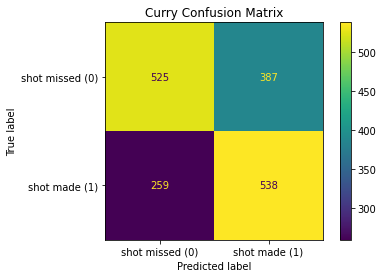

In [27]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
#raise NotImplementedError()
instructor_precision = 538/(538+387)
instructor_recall = 538/(538+259)
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [28]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. Does your model have higher recall or higher precision? How does your model's metrics compare to the metrics you calculated above?

In [30]:
'''T10. Plot ROC curve.'''
# YOUR CODE HERE
#raise NotImplementedError()
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.66      0.59      0.63       912
           1       0.58      0.65      0.62       797

    accuracy                           0.62      1709
   macro avg       0.62      0.62      0.62      1709
weighted avg       0.63      0.62      0.62      1709



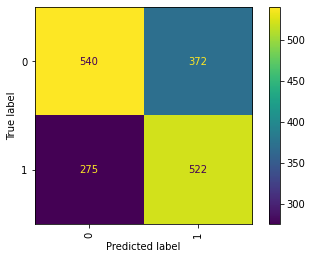

In [31]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test,values_format='.0f', xticks_rotation='vertical' );

In [33]:
my_precision = 522/(522+372)
my_recall = 522/(522+275)
print('my model precision', my_precision)
print('my model recall', my_recall)
print("I've got a slightly higher precisio but a lowe recall")

my model precision 0.5838926174496645
my model recall 0.6549560853199499
I've got a slightly higher precisio but a lowe recall
